<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



# Thermal-Diffuse Scattering


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_08-Thermal_Diffuse_Scattering.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Imaging/CH3_08-Thermal_Diffuse_Scattering.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

> Note: This notebook needs a Linux environment and is most easily run in Colab with the button above

## Load important packages

> In Colab, the next code cell must be run first

### Check Installed Packages

In [4]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
    !pip install ase -q
    !pip install ipympl -q
    !pip install abtem -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2023.3.0':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
    if test_package('abtem') < '1.0.0b17':
        print('installing abtem')
        !{sys.executable} -m pip install  --upgrade abtem -q
# ------------------------------
print('done')

installing abtem
done


### Load Packages
We will use 
- numpy and matplotlib (installed with magic comand **%pylab**.)
- physical constants from scipy
- The pyTEMlib kinematic scattering librarty is only used to determine the wavelength.

In [5]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %matplotlib ipympl
    from google.colab import output
    output.enable_custom_widget_manager()
else:    
    %matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
# import atomic simulation environment
import ase
import ase.spacegroup
import ase.visualize

# import abintio-tem library
import abtem

__notebook__ = 'CH3-08-Thermal_Diffuse_Scattering'
__notebook_version__ = '2021_03_29'


## Multislice Algorithm

As in the Dynamic Diffraction part in the [Multislice notebook](../Diffraction/CH2_D02-Multislice.ipynb), we first define the potential of the slices.

However, here we do this with the ``abtem`` package and the structure is made with the ``ase`` package

### Defining the structure
Here we make a SrTiO$_3$ crystal again

In [6]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(4, 4, 16))
srtio3.center()
ase.visualize.view(srtio3, viewer='x3d')  

However, as before we need more atoms laterally and more layers.
> Please note:
>
> all length in abTEM are in Angstrom

Simulation cell: Cell([31.24, 31.24, 312.4])


<IPython.core.display.Javascript object>


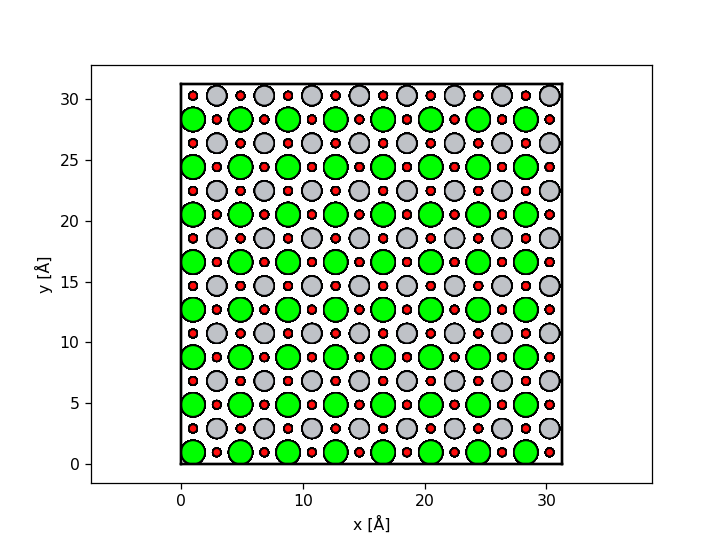

In [7]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = ase.spacegroup.crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(8, 8, 80))

srtio3.center()
print(f"Simulation cell: {srtio3.cell}")
abtem.show_atoms(srtio3);

### Defining the potential

In [8]:
potential = abtem.Potential(srtio3, 
                      gpts=512, 
                      slice_thickness=3.904/2, 
                      parametrization='kirkland', 
                      projection='infinite')

potential.sampling
wave = abtem.PlaneWave(energy=200e3, sampling=.05)

### Multislice

/home/nyd/anaconda3/envs/ase/lib/python3.10/site-packages/abtem/base_classes.py:491: UserWarning: Overspecified simulation grid sampling ((0.061015625, 0.061015625) != (0.05, 0.05))
  warnings.warn(f'Overspecified simulation grid sampling ({self.sampling} != {other.sampling})')


Potential:   0%|          | 0/161 [00:00<?, ?it/s]

Multislice:   0%|          | 0/161 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


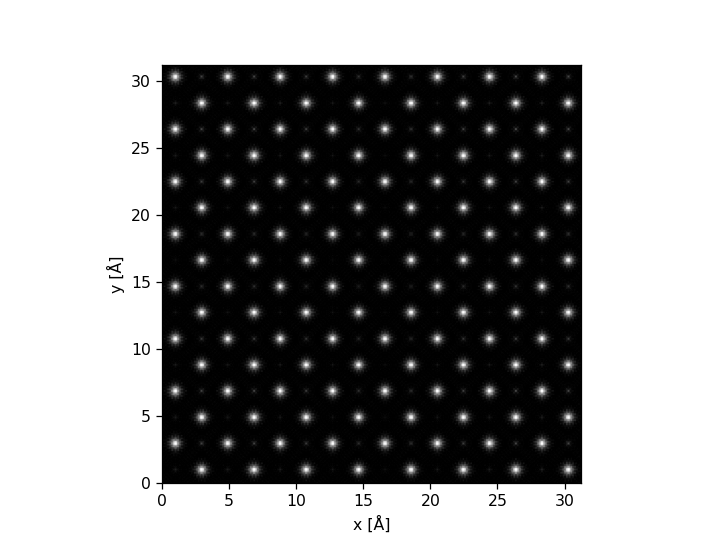

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f3a70b3dc30>)

In [9]:
exit_wave = wave.multislice(potential)
exit_wave.show()

### Plot Diffraction Pattern

<IPython.core.display.Javascript object>


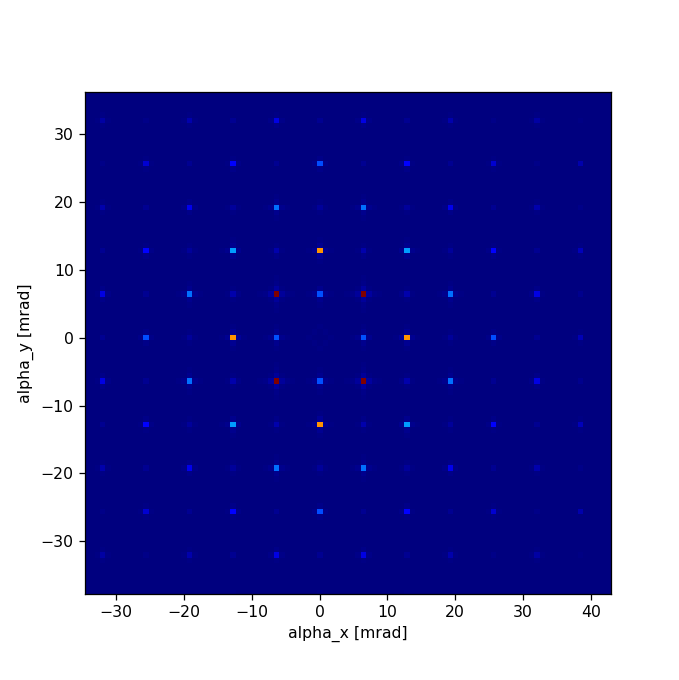

In [10]:
diffraction_pattern = exit_wave.diffraction_pattern()
diffraction_pattern = abtem.measure.block_zeroth_order_spot(diffraction_pattern)

ax, im = diffraction_pattern.show(power=.4, figsize=(6,6), cmap='jet')

## Thermal Diffuse Scattering
The atoms in any real material are not exactly located at their symmetrical lattice points due to thermal and zero-point vibrations. The ``frozen phonon`` approximation is a simple to simulate the effects of thermal vibrations. 

The scattering that is associated with thermal lattice vibrations is called ``thermal diffuse scattering (TDS)``.
In the following, we investigate the effect of thermal diffuse scattering in the frozen phonon approximation on diffraction pattern.

### Structure and Debey Waller Factor

Each atom is allowed to deviate from its symmetrical lattice position with a Gaussian distribution and
an ``root mean square`` **rms** deviation of $x_{RMS}$  in each of three directions. This is equivalent to the Einstein model of the density of states for phonons.

This standard deviation of this Gaussiam distribution $x_{RMS}$ for most materials is about 0.1Å:

The relation of the Debey-Waller Factors in the literature to the deviation of position $x_{RMS} = \sqrt{B/(8\pi^2)}$.

The ``FrozenPhonon class`` of the abtem package generates offsets from such a Gaussian distribution  using a random number generator with a given seed. 

The standard deviation of the Gaussian distribution is provided for each element as a dictionary.


In [11]:
# ------ Input ------ #
number_of_frozen_phonon_runs = 12
# --------------------#
frozen_phonons = abtem.FrozenPhonons(srtio3, number_of_frozen_phonon_runs, {'Sr' : .1, 'Ti' : .1, 'O' : .1}, seed=1)

<IPython.core.display.Javascript object>


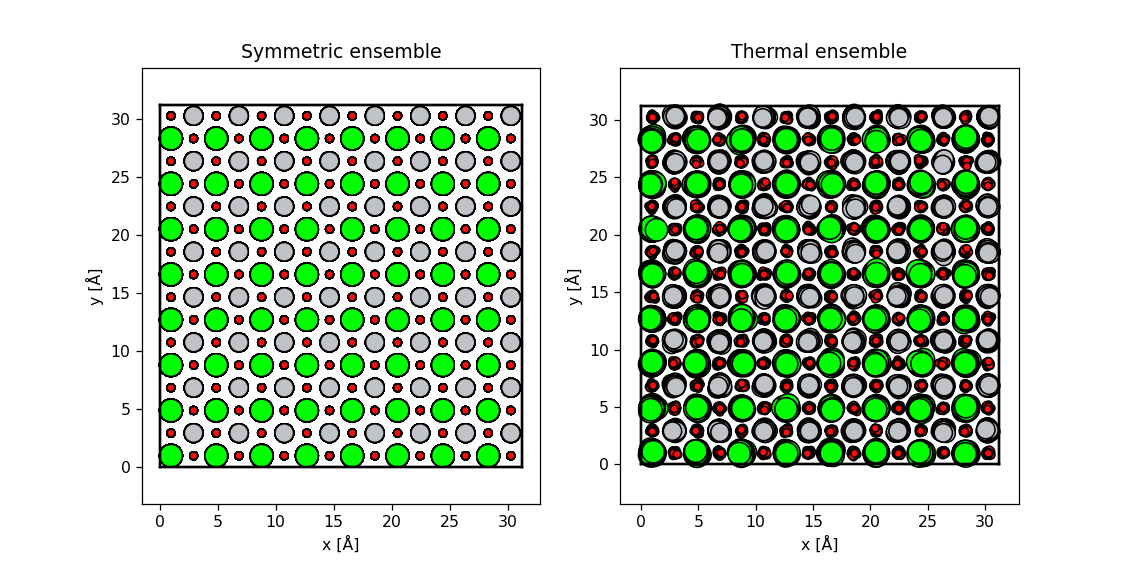

In [12]:
atoms_conf = next(iter(frozen_phonons))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

abtem.show_atoms(srtio3, ax=ax1)

abtem.show_atoms(atoms_conf, ax=ax2);
ax1.set_title('Symmetric ensemble')
ax2.set_title('Thermal ensemble');

### Building a potential 

In [13]:
tds_potential = abtem.Potential(frozen_phonons, gpts=512, slice_thickness=3.905/2, 
                                projection='infinite', parametrization='kirkland')
print(f"Real space sampling: {tds_potential.sampling} Angstrom ")

Real space sampling: (0.061015625, 0.061015625) Angstrom 


In [14]:
tds_exit_waves = wave.multislice(tds_potential, pbar=True)

/home/nyd/anaconda3/envs/ase/lib/python3.10/site-packages/abtem/base_classes.py:487: UserWarning: Overspecified simulation grid gpts ((512, 512) != (625, 625))
  warnings.warn(f'Overspecified simulation grid gpts ({self.gpts} != {other.gpts})')
/home/nyd/anaconda3/envs/ase/lib/python3.10/site-packages/abtem/base_classes.py:491: UserWarning: Overspecified simulation grid sampling ((0.061015625, 0.061015625) != (0.049983999633789064, 0.049983999633789064))
  warnings.warn(f'Overspecified simulation grid sampling ({self.sampling} != {other.sampling})')


TDS:   0%|          | 0/12 [00:00<?, ?it/s]

Multislice:   0%|          | 0/160 [00:00<?, ?it/s]

Potential:   0%|          | 0/160 [00:00<?, ?it/s]

### Averaging thermal diffuse scattering calculations.

The need for averaging of the thermal diffuse scattering becomes clear in  the following figure.

Each atom position has to have many deviations to be averaged out in the center. This is waht makes this process so long and what makes the process obvious for (embarrassingly) parallel methods.

<IPython.core.display.Javascript object>


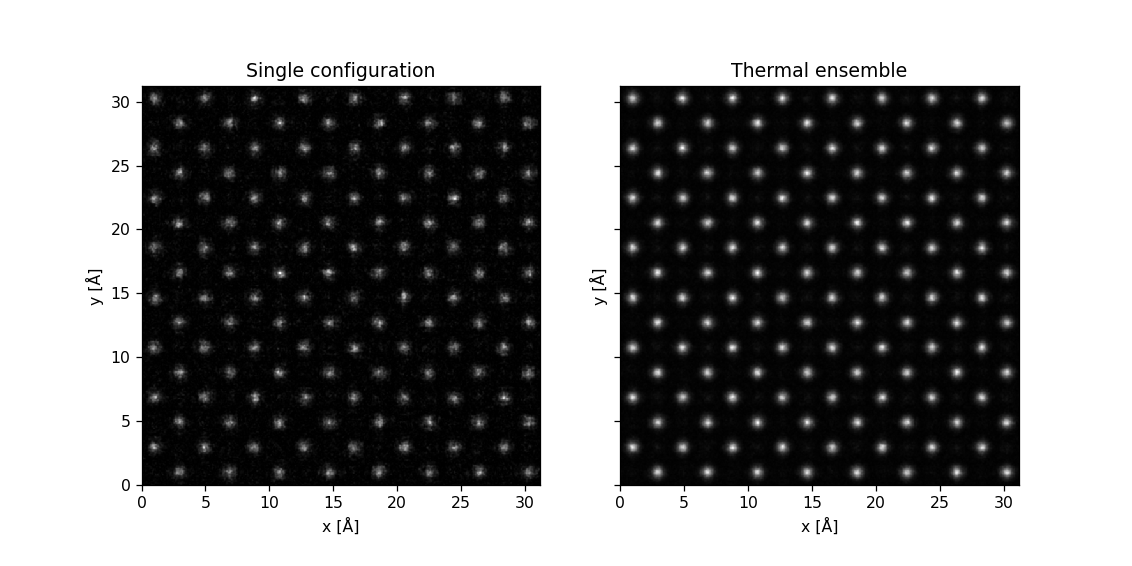

Text(0.5, 1.0, 'Thermal ensemble')

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

tds_exit_waves[0].show(ax=ax1)
ax1.set_title('Single configuration')
tds_exit_waves.intensity().mean(0).show(ax=ax2)
ax2.set_title('Thermal ensemble')

### Plot Diffraction Pattern

The Kikuchi notebook explained that the source for the Kikuchi pattern formation is inside the sample. Here we have the origin of this source. The thermal diffuse scattering makes the electrons scatter into high angles and that is needed to capture these features in a simulation. 

> So when you see Kikuchi bands you actually see the effect of phonons.


<IPython.core.display.Javascript object>


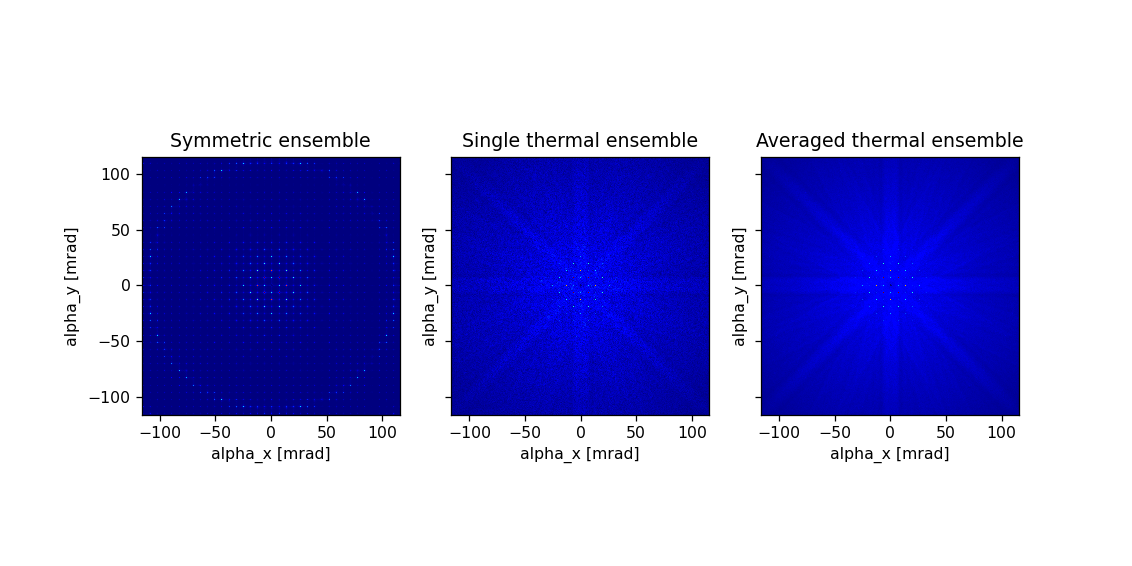

Text(0.5, 1.0, 'Averaged thermal ensemble')

In [16]:
tds_diffraction_pattern = tds_exit_waves.diffraction_pattern('valid', block_zeroth_order=True)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5), sharex=True, sharey=True)

diffraction_pattern.show(power=.25, cmap='jet', ax=ax1)
ax1.set_title('Symmetric ensemble')
tds_diffraction_pattern[0].show(power=.25, cmap='jet', ax=ax2)
ax2.set_title('Single thermal ensemble')

tds_diffraction_pattern.mean(0).show(ax=ax3, cmap='jet', power=.25, )
ax3.set_title('Averaged thermal ensemble')

## CBED and Thermal Diffuse Scattering

### Make the probe 
The probe has to be on the same grid (matrix, pixels) as the potential, which is ensured with the ``grid.match`` function.

In [17]:
# ---- Input ----- #
convergence_angle = 20  # in mrad of half angle
acceleration_voltage = 80e3 # in V
defocus = 40  # in nm
# -----------------#

probe = abtem.Probe(energy=acceleration_voltage, semiangle_cutoff=convergence_angle, 
                    rolloff=0.1, defocus=defocus, Cs=3e5, focal_spread=20)
probe.grid.match(potential)

### Symmetric ensemble

Potential:   0%|          | 0/161 [00:00<?, ?it/s]

Multislice:   0%|          | 0/161 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


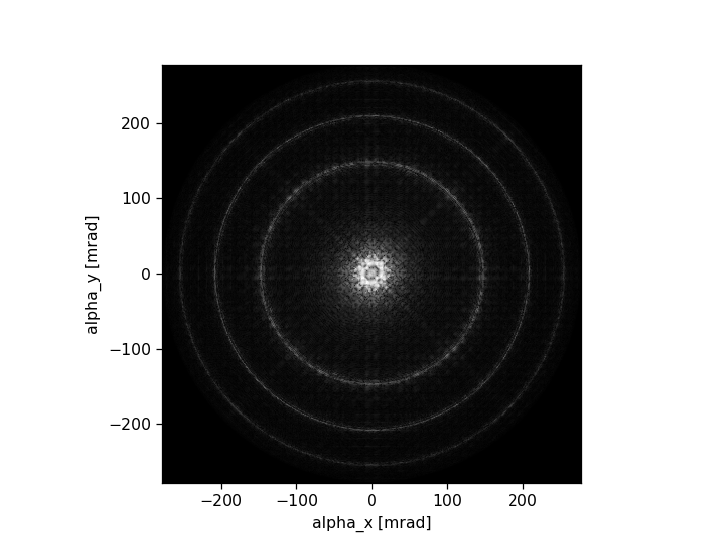

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f3a6d73d210>)

In [18]:
detector = abtem.PixelatedDetector(max_angle='limit')
cbed = probe.build().multislice(potential, pbar=True, detector=detector)
cbed.show(power=0.25)

### TDS
For the thermal diffuse scattering like above for the symetric ensemble we reuse the potential from the plane wave calculation and just change the probe. The probe was definded in the symmetric enseble calculation above.

The calculation takes about 5 min on my laptop.

TDS:   0%|          | 0/12 [00:00<?, ?it/s]

Multislice:   0%|          | 0/160 [00:00<?, ?it/s]

Potential:   0%|          | 0/160 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


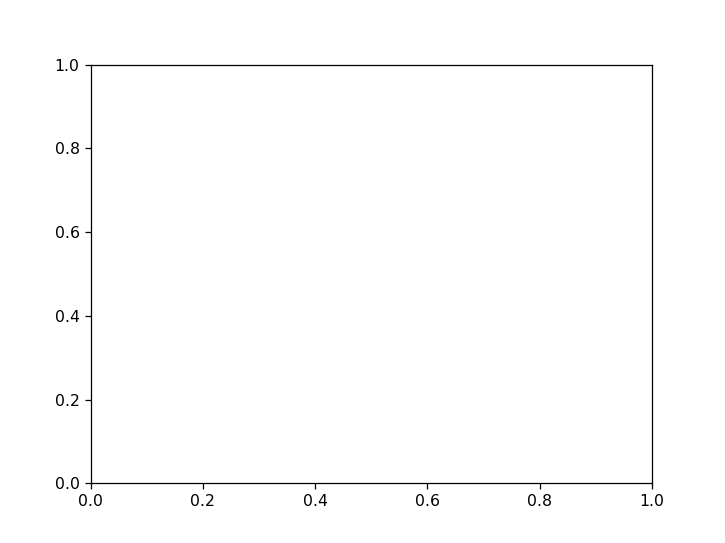

AttributeError: 'Line2D' object has no property 'power'

In [19]:
detector = abtem.PixelatedDetector(max_angle='limit')
probe.grid.match(tds_potential)
tds_cbed = probe.build().multislice(tds_potential, pbar=True, detector=detector)
tds_cbed.mean(0).show(power=0.25)

### Comparison

<IPython.core.display.Javascript object>


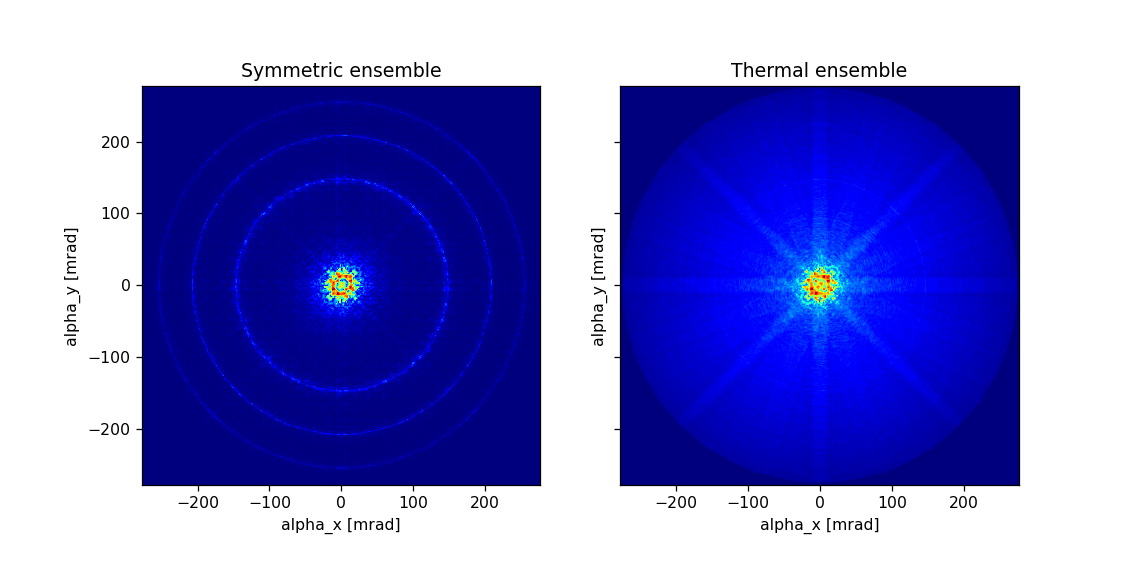

Text(0.5, 1.0, 'Thermal ensemble')

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

cbed.show(power=.4, cmap='jet', ax=ax1)
ax1.set_title('Symmetric ensemble')
tds_cbed.show(power=.3, cmap='jet', ax=ax2)
ax2.set_title('Thermal ensemble')

Redo this calculation with non overlapping disks in the convergence angle (let's say 7 mrad at 80keV)
You can jump to [Make the probe](###Make_the_probe)

## Summary

For a quantitative image simulation we need to do dynamic scattering theory. 

The dynamic scattering theory is done within the multislice algorithm that treats each slice like a weak phase object.


>
> Thermal defuse scattering needs to be included into the multislice calculations for a good simulation
>

The thermal diffuse scattering can be approximated by the frozen phonon approximation but it is computationally intensive.